# Bike Regression

This is my 5th and final try at the bike regression ML project. I figured that attempt 4 was too messy, in that the workflows felt too wobbly. To improve from the previous iteration, I sought help online, and the result is that it brought a good amount of structure into my project.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# preprocessing
from scipy.stats import pearsonr
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# resampling
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

import pickle

#### 1. Load Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### 2. Explore Data
- Descriptive statistics
- Data cleaning 
- Feature engineering
- Data visualizations

In [3]:
# verify no duplicate / nulls
print("train duplicated: {}".format(train.duplicated().sum()))
print("test duplicated: {}".format(test.duplicated().sum()))
print("train nulls: {}".format(train.isnull().any().sum()))
print("test nulls: {}".format(test.isnull().any().sum()))

train duplicated: 0
test duplicated: 0
train nulls: 0
test nulls: 0


In [4]:
# basic information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
def plot_boxplots(data):
    nrows = (len(data.columns) // 4) + 1
    plt.figure(figsize=(25, nrows * 5))
    sns.set(font_scale = 1)
    columns = data.columns
    for i in range(len(columns)):
        plt.subplot(nrows, 4, i+1)
        sns.boxplot(y = data[columns[i]])  
        
def plot_histograms(data):
    nrows = (len(data.columns) // 4) + 1
    plt.figure(figsize=(25, nrows * 5))
    sns.set(font_scale = 1)
    columns = data.columns
    for i in range(len(columns)):
        plt.subplot(nrows, 4, i+1)
        sns.histplot(x = data[columns[i]])  

In [8]:
def datetime_breakdown(data, column_name):
    df = data.copy()
    df[column_name] = df[column_name].apply(pd.to_datetime, format = '%Y-%m-%d')
    df[column_name + '_year'] = df[column_name].dt.year
    df[column_name + '_month'] = df[column_name].dt.month
    df[column_name + '_day'] = df[column_name].dt.day
    df[column_name + '_hour'] = df[column_name].dt.hour
    return df.drop(column_name, axis = 1)

In [9]:
# assumes that datetime starts from 0 to max_datetime - 1. eg. hour ranges from 0 to 23, not 1 to 24
# only works properly for month, day, hour

def cyclic_datetime(data, column_name, datetime_type):
    df = data.copy()
    divided_by = 0
    if datetime_type == 'hour':
        divided_by = 24
        df['sin_' + column_name] = np.sin(df[column_name] * (2 * np.pi / divided_by)) # no need to -1 since min hour = 0
        df['cos_' + column_name] = np.cos(df[column_name] * (2 * np.pi / divided_by))
    else:
        if datetime_type == 'month':
            divided_by = 12
        if datetime_type == 'day': 
            divided_by = 30
        df['sin_' + column_name] = np.sin((df[column_name] - 1) * (2 * np.pi / divided_by)) # -1 since min day / min month = 1
        df['cos_' + column_name] = np.cos((df[column_name] - 1) * (2 * np.pi / divided_by))
    df = df.drop(column_name, axis = 1)
    return df

In [10]:
train = datetime_breakdown(train, 'datetime')

In [11]:
times = ['datetime_month', 'datetime_hour', 'datetime_day']
datetime_type = ['month', 'hour', 'day']
train_after_date = train.copy()
for i in range(0, len(times)):
    train_after_date = cyclic_datetime(train_after_date, times[i], datetime_type[i])

In [12]:
train_after_date.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count',
       'datetime_year', 'sin_datetime_month', 'cos_datetime_month',
       'sin_datetime_hour', 'cos_datetime_hour', 'sin_datetime_day',
       'cos_datetime_day'],
      dtype='object')

In [13]:
# drop registered and casual since they add up to count
continuous_variables = ['temp', 'atemp', 'humidity', 'windspeed', 'sin_datetime_month',
                        'cos_datetime_month', 'sin_datetime_hour', 'cos_datetime_hour', 
                        'sin_datetime_day', 'cos_datetime_day', 'count']
categorical_variables = ['season', 'holiday', 'workingday', 'weather', 'datetime_year']

In [14]:
train_after_date = train_after_date[continuous_variables + categorical_variables]

In [15]:
train_after_date.head()

,temp,atemp,humidity,windspeed,sin_datetime_month,cos_datetime_month,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,count,season,holiday,workingday,weather,datetime_year
0,9.84,14.395,81,0.0,0.0,1.0,0.000000,1.000000,0.0,1.0,16,1,0,0,1,2011
1,9.02,13.635,80,0.0,0.0,1.0,0.258819,0.965926,0.0,1.0,40,1,0,0,1,2011
2,9.02,13.635,80,0.0,0.0,1.0,0.500000,0.866025,0.0,1.0,32,1,0,0,1,2011
3,9.84,14.395,75,0.0,0.0,1.0,0.707107,0.707107,0.0,1.0,13,1,0,0,1,2011
4,9.84,14.395,75,0.0,0.0,1.0,0.866025,0.500000,0.0,1.0,1,1,0,0,1,2011


In [16]:
train_continuous = train_after_date[continuous_variables]

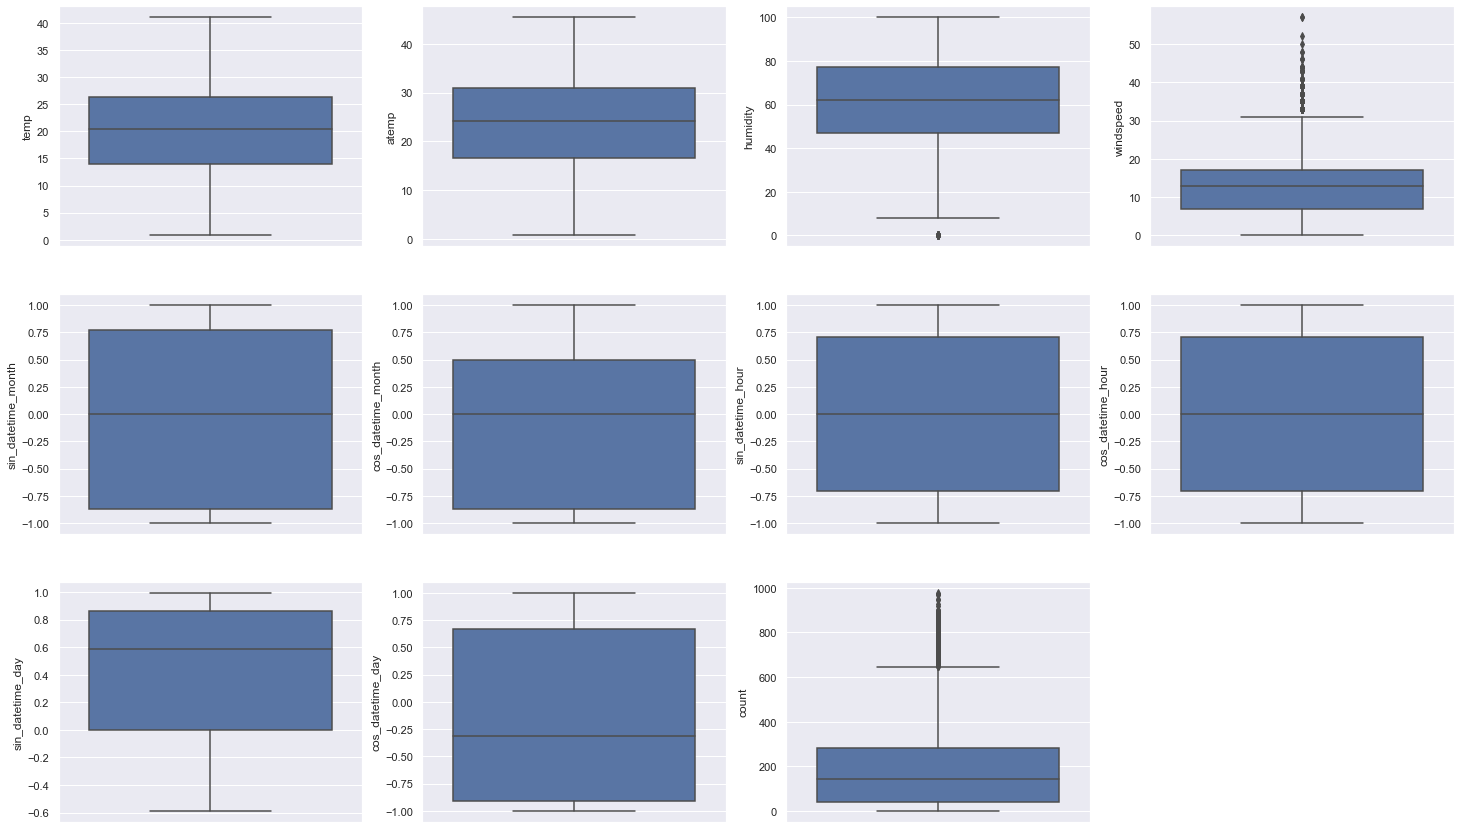

In [17]:
plot_boxplots(train_continuous)

# windspeed and cnt have numerous univariate outliers 

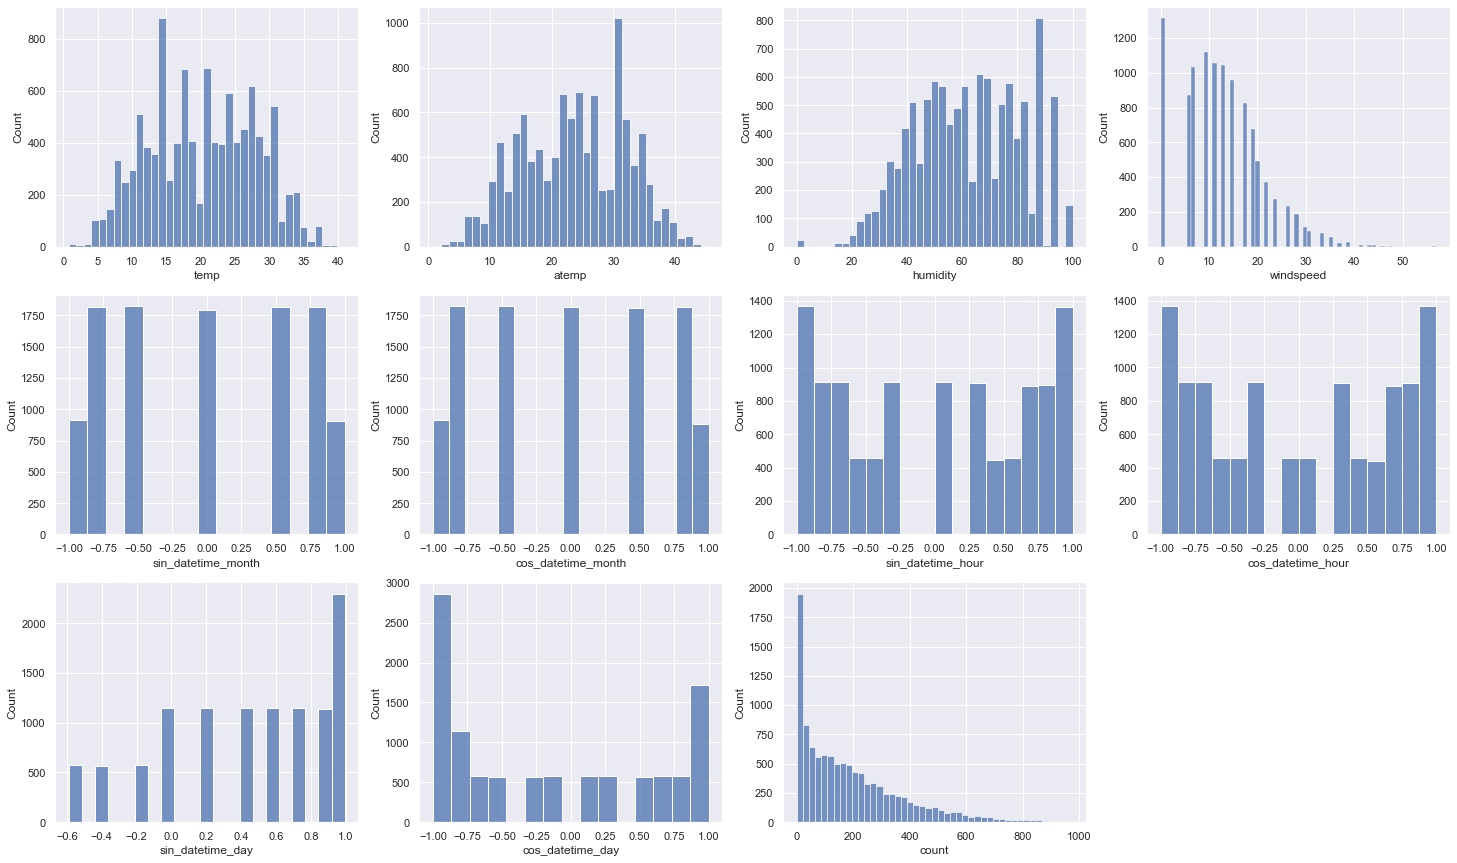

In [18]:
plot_histograms(train_continuous)

Observations:
- Boxplot:
    - windspeed and count have many outliers 
    - humidity = 0? 
- Histograms:
    - windspeed and count are quite skewed

In [19]:
X_train_continuous = train_after_date[continuous_variables].drop('count', axis = 1)
y_train = train_after_date[['count']]

In [20]:
# encode categorical variables 
train_encoded = pd.concat([X_train_continuous, 
                          pd.get_dummies(train_after_date[categorical_variables].astype('category'), drop_first = True), 
                          y_train], axis = 1)

In [21]:
train_encoded.head()

,temp,atemp,humidity,windspeed,sin_datetime_month,cos_datetime_month,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,datetime_year_2012,count
0,9.84,14.395,81,0.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0,0,0,0,0,0,0,0,0,16
1,9.02,13.635,80,0.0,0.0,1.0,0.258819,0.965926,0.0,1.0,0,0,0,0,0,0,0,0,0,40
2,9.02,13.635,80,0.0,0.0,1.0,0.500000,0.866025,0.0,1.0,0,0,0,0,0,0,0,0,0,32
3,9.84,14.395,75,0.0,0.0,1.0,0.707107,0.707107,0.0,1.0,0,0,0,0,0,0,0,0,0,13
4,9.84,14.395,75,0.0,0.0,1.0,0.866025,0.500000,0.0,1.0,0,0,0,0,0,0,0,0,0,1


In [22]:
encoded_continuous_variables = list(train_encoded.columns)[:10] + [train_encoded.columns[-1]]
encoded_categorical_variables = list(train_encoded.columns)[10:-1]

In [23]:
# Find Point biserial correlation
def point_biserial_correl(data, categorical_variables, continuous_variables):
    print("--- point biserial ---")
    for cat_var in categorical_variables:
        for cont_var in  continuous_variables:
            data_cat = data[cat_var].to_numpy()
            data_cont = data[cont_var].to_numpy()

            corr, p_val = pointbiserialr(x=data_cat, y=data_cont)
            if np.abs(corr) >= 0.75:
                print(f'Categorical variable: {cat_var}, Continuous variable: {cont_var}, correlation: {corr}')

In [24]:
# Find Cramer's V correlation
def cramer_v_correl(data, categorical_variables):
    print("--- cramer v ---")
    total_len = len(categorical_variables)
    for idx1 in range(total_len-1):
        for idx2 in range(idx1+1, total_len):
            cat_var1 = categorical_variables[idx1]
            cat_var2 = categorical_variables[idx2]    
            c_matrix = pd.crosstab(data[cat_var1], data[cat_var2])
            chi2 = chi2_contingency(c_matrix)[0]
            n = c_matrix.sum().sum()
            phi2 = chi2/n
            r,k = c_matrix.shape
            phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
            rcorr = r-((r-1)**2)/(n-1)
            kcorr = k-((k-1)**2)/(n-1)
            corr = np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
            if corr >= 0.75:
                print(f'categorical variable 1 {cat_var1}, categorical variable 2: {cat_var2}, correlation: {corr}')

In [25]:
# Find Pearson correlation
def pearson_correl(data, continuous_variables):
    print("--- pearson ---")
    total_len = len(continuous_variables)
    for idx1 in range(total_len-1):
        for idx2 in range(idx1+1, total_len):
            cont_var1 = continuous_variables[idx1]
            cont_var2 = continuous_variables[idx2]
            data_cont1 = data[cont_var1].to_numpy()
            data_cont2 = data[cont_var2].to_numpy()
            corr, p_val = pearsonr(x=data_cont1, y=data_cont2)
            if np.abs(corr) >= 0.75:
                print(f'Variable 1: {cont_var1}, Variable 2: {cont_var2}, correlation: {corr}')

In [26]:
point_biserial_correl(train_encoded, encoded_categorical_variables, encoded_continuous_variables)
cramer_v_correl(train_encoded, encoded_categorical_variables)
pearson_correl(train_encoded, encoded_continuous_variables)

--- point biserial ---
--- cramer v ---
--- pearson ---
Variable 1: temp, Variable 2: atemp, correlation: 0.9849481104817073
Variable 1: temp, Variable 2: cos_datetime_month, correlation: -0.8560196876577529
Variable 1: atemp, Variable 2: cos_datetime_month, correlation: -0.8380928348221115


In [27]:
# drop because of correlation : 'sin_datetime_month', 'cos_datetime_month', 'atemp'
train_after_corr = train_encoded.drop(['atemp', 'cos_datetime_month', 'sin_datetime_month'], axis = 1)

In [28]:
train_after_corr.columns

Index(['temp', 'humidity', 'windspeed', 'sin_datetime_hour',
       'cos_datetime_hour', 'sin_datetime_day', 'cos_datetime_day', 'season_2',
       'season_3', 'season_4', 'holiday_1', 'workingday_1', 'weather_2',
       'weather_3', 'weather_4', 'datetime_year_2012', 'count'],
      dtype='object')

In [29]:
continuous_variables_after_corr = list(train_after_corr.columns[0:7]) + [train_after_corr.columns[-1]]
categorical_variables_after_corr = list(train_after_corr.columns[7:-1])

In [30]:
train_after_corr.head()

,temp,humidity,windspeed,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,datetime_year_2012,count
0,9.84,81,0.0,0.000000,1.000000,0.0,1.0,0,0,0,0,0,0,0,0,0,16
1,9.02,80,0.0,0.258819,0.965926,0.0,1.0,0,0,0,0,0,0,0,0,0,40
2,9.02,80,0.0,0.500000,0.866025,0.0,1.0,0,0,0,0,0,0,0,0,0,32
3,9.84,75,0.0,0.707107,0.707107,0.0,1.0,0,0,0,0,0,0,0,0,0,13
4,9.84,75,0.0,0.866025,0.500000,0.0,1.0,0,0,0,0,0,0,0,0,0,1


In [31]:
point_biserial_correl(train_after_corr, categorical_variables_after_corr, continuous_variables_after_corr)
cramer_v_correl(train_after_corr, categorical_variables_after_corr)
pearson_correl(train_after_corr, continuous_variables_after_corr)

--- point biserial ---
--- cramer v ---
--- pearson ---


In [32]:
def check_vif(data):
    vif = pd.DataFrame()
    vif["feature"] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    print(vif.sort_values(by = 'VIF', ascending = False))

In [33]:
check_vif(train_after_corr[continuous_variables_after_corr].drop('count', axis = 1))

             feature       VIF
1           humidity  6.653444
0               temp  6.204104
2          windspeed  2.948874
5   sin_datetime_day  1.938534
3  sin_datetime_hour  1.220930
6   cos_datetime_day  1.149501
4  cos_datetime_hour  1.134140


In [34]:
train_after_corr = train_after_corr.drop('humidity', axis = 1)
continuous_variables_after_corr.remove('humidity')

In [35]:
check_vif(train_after_corr[continuous_variables_after_corr].drop('count', axis = 1))

             feature       VIF
0               temp  3.012265
1          windspeed  2.752681
4   sin_datetime_day  1.849328
5   cos_datetime_day  1.142715
2  sin_datetime_hour  1.017329
3  cos_datetime_hour  1.016598


In [36]:
validation_size = 0.20
seed = 42
numfolds = 10
scoring = 'neg_mean_squared_log_error'

In [37]:
X_train = train_after_corr.drop('count', axis = 1)
y_train = np.log(train_after_corr['count'] + 1)

In [38]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=seed)

In [39]:
X_train.head()

,temp,windspeed,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,datetime_year_2012
2815,27.88,6.0032,0.965926,0.258819,0.866025,0.500000,0,1,0,0,1,0,0,0,0
8695,36.90,19.9995,-0.866025,-0.500000,0.587785,0.809017,0,1,0,0,0,0,0,0,1
8406,32.80,16.9979,-0.707107,-0.707107,0.866025,-0.500000,0,1,0,0,1,0,0,0,1
1543,14.76,7.0015,0.866025,0.500000,0.951057,-0.309017,1,0,0,0,0,1,0,0,0
4952,13.12,16.9979,0.500000,-0.866025,-0.587785,-0.809017,0,0,1,0,0,0,0,0,0


In [40]:
y_train

2815    3.583519
8695    6.111467
8406    5.624018
1543    1.791759
4952    5.303305
          ...   
5734    3.663562
5191    5.010635
5390    5.459586
860     3.135494
7270    5.883322
Name: count, Length: 8708, dtype: float64

#### 3. Evaluate Algorithms
- Test options and evaluation metric
- Compare Algorithms

In [41]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=numfolds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.039978 (0.003083)
LASSO: -0.087951 (0.007111)
KNN: -0.046301 (0.003524)
CART: -0.015005 (0.001702)


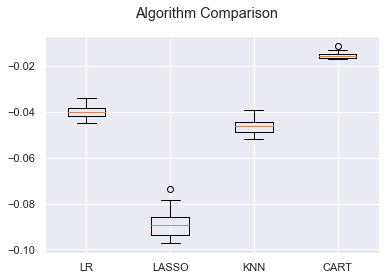

In [42]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Decision Tree takes the cake easily. But the performance of algorithms like LASSO and KNN may be downplayed because continuous values are not scaled. I will try scaling the variables

In [43]:
pipelines = [
    ('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])),
    ('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])),
    ('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])),
    ('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])),
]

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=numfolds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.039978 (0.003083)
ScaledLASSO: -0.098824 (0.008254)
ScaledKNN: -0.021445 (0.002171)
ScaledCART: -0.015088 (0.001517)


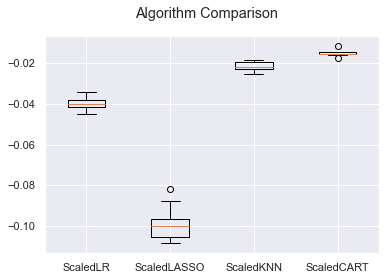

In [44]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Indeed, KNN performs better. But Decision Tree still takes the cake.

#### 4: Improving algorithms
- Tune candidate algorithms
- Ensemble methods
- Tune ensemble methods

In [45]:
param_grid = [
    {'max_depth' : [10, 15, 20, 25, 30]}
]
model = DecisionTreeRegressor()
kfold = KFold(n_splits=numfolds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, y_train)

In [46]:
print("best score, param: {} {}".format(grid_result.best_score_, grid_result.best_params_))

best score, param: -0.011441543453214228 {'max_depth': 10}


In [47]:
ensembles = [
    ('AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])),
    ('XGB', Pipeline([('Scaler', StandardScaler()),('GBM', XGBRegressor(verbosity = 0))])),
    ('RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])),   
]
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=numfolds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: -0.021393 (0.002048)
XGB: -0.007101 (0.000753)
RF: -0.008374 (0.000950)


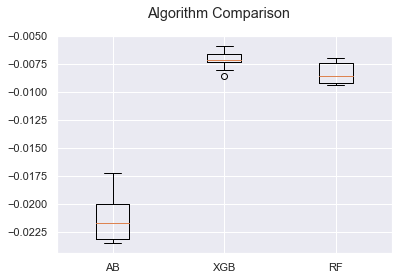

In [48]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

XGBoost and RF perform twice as good as DT. We can consider tuning XGBoost seeing that it performs the best

In [50]:
param_grid = {
        'max_depth': range(2, 11),
        'min_child_weight' : range(1,10,1),
        'learning_rate': [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
        'subsample': [i/10.0 for i in range(3,10)],
        'colsample_bytree': [i/10.0 for i in range(3,10)],
        'min_child_weight': range(1, 10),
        'gamma': [i/10.0 for i in range(0,5)],
        'n_estimators': range(100, 1500, 100)
}
model = XGBRegressor() 
kfold = KFold(n_splits=numfolds, random_state=seed, shuffle=True)
grid = RandomizedSearchCV(model, param_grid, n_iter=25, 
                               n_jobs=-1, cv=kfold, scoring=scoring, random_state=42)
grid_result = grid.fit(X_train, y_train)

In [51]:
print("best cv score, param : {} {}".format(grid_result.best_score_, grid_result.best_params_))

best cv score, param : -0.007009601897233993 {'subsample': 0.6, 'n_estimators': 1300, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.7}


In [64]:
final_model = XGBRegressor(subsample = 0.6, n_estimators = 1300, min_child_weight = 2, max_depth = 4, 
                          learning_rate = 0.03, gamma = 0.1, colsample_bytree = 0.7, random_state = 42,
                          use_label_encoder = False, verbosity = 0)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_validation)

In [70]:
mean_squared_error(y_validation, y_pred, squared=False)

0.31929171232064896

#### Predict test 

What transformations have been onto the train set? 
- datetime breakdown
- datetime cyclic
- drop atemp, month
- encode categoricals 

We now apply these transformations onto the test set before feeding the test data into our best model

Also need to reverse the effects of log(pred + 1)

In [53]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [54]:
test_transformed = (test
 .pipe(datetime_breakdown, 'datetime')
 .pipe(pd.DataFrame.drop, 'atemp', axis = 1)
 .pipe(pd.DataFrame.drop, 'datetime_month', axis = 1)
 .pipe(cyclic_datetime, 'datetime_day', 'day')
 .pipe(cyclic_datetime, 'datetime_hour', 'hour')                    
)

In [55]:
test_transformed.head()

,season,holiday,workingday,weather,temp,humidity,windspeed,datetime_year,sin_datetime_day,cos_datetime_day,sin_datetime_hour,cos_datetime_hour
0,1,0,1,1,10.66,56,26.0027,2011,-0.743145,-0.669131,0.000000,1.000000
1,1,0,1,1,10.66,56,0.0000,2011,-0.743145,-0.669131,0.258819,0.965926
2,1,0,1,1,10.66,56,0.0000,2011,-0.743145,-0.669131,0.500000,0.866025
3,1,0,1,1,10.66,56,11.0014,2011,-0.743145,-0.669131,0.707107,0.707107
4,1,0,1,1,10.66,56,11.0014,2011,-0.743145,-0.669131,0.866025,0.500000


In [56]:
continuous_variables_after_corr

['temp',
 'windspeed',
 'sin_datetime_hour',
 'cos_datetime_hour',
 'sin_datetime_day',
 'cos_datetime_day',
 'count']

In [57]:
categorical_variables_after_corr

['season_2',
 'season_3',
 'season_4',
 'holiday_1',
 'workingday_1',
 'weather_2',
 'weather_3',
 'weather_4',
 'datetime_year_2012']

In [58]:
test_cont_variables = continuous_variables_after_corr[:-1]
test_cat_variables = categorical_variables_after_corr

In [59]:
test_continuous = test_transformed[test_cont_variables]
test_categorical = pd.get_dummies(test_transformed[categorical_variables].astype('category'), drop_first=True)
X_test = pd.concat([test_continuous, test_categorical], axis = 1)

In [60]:
X_test.head()

,temp,windspeed,sin_datetime_hour,cos_datetime_hour,sin_datetime_day,cos_datetime_day,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,weather_4,datetime_year_2012
0,10.66,26.0027,0.000000,1.000000,-0.743145,-0.669131,0,0,0,0,1,0,0,0,0
1,10.66,0.0000,0.258819,0.965926,-0.743145,-0.669131,0,0,0,0,1,0,0,0,0
2,10.66,0.0000,0.500000,0.866025,-0.743145,-0.669131,0,0,0,0,1,0,0,0,0
3,10.66,11.0014,0.707107,0.707107,-0.743145,-0.669131,0,0,0,0,1,0,0,0,0
4,10.66,11.0014,0.866025,0.500000,-0.743145,-0.669131,0,0,0,0,1,0,0,0,0


In [71]:
pd.concat([test['datetime'], pd.DataFrame({'count' : np.exp(final_model.predict(X_test)) - 1})], axis=1).to_csv('predict.csv', index=False)

This yielded a test score of 0.394 on kaggle, placing this solution in the top 10 percentile